### Ground Point. Packages and the dataset

In [1]:
import numpy as np
np.random.seed(1001)
import warnings
import wave
import librosa
import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
from tqdm import tqdm_notebook
from tqdm import tqdm
#from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
data = pd.read_csv("train_curated.csv")
sub = pd.read_csv("sample_submission.csv")

In [3]:
data.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


### 1. Data Preprocessing: 
Get rid of the multi-labeled audio records

In [4]:
data = data[data.labels.isin(sub.columns[1:])]
print(len(data))

4269


In [5]:
grouped_data = data.groupby(['labels']).count()
grouped_data.columns = ['counts']
print(len(grouped_data))
grouped_data

74


,counts
labels,
Accelerating_and_revving_and_vroom,32
Accordion,47
Acoustic_guitar,3
Bark,69
Bass_drum,68
...,...
Waves_and_surf,71
Whispering,68
Writing,72


Text(0, 0.5, 'Number of Samples')

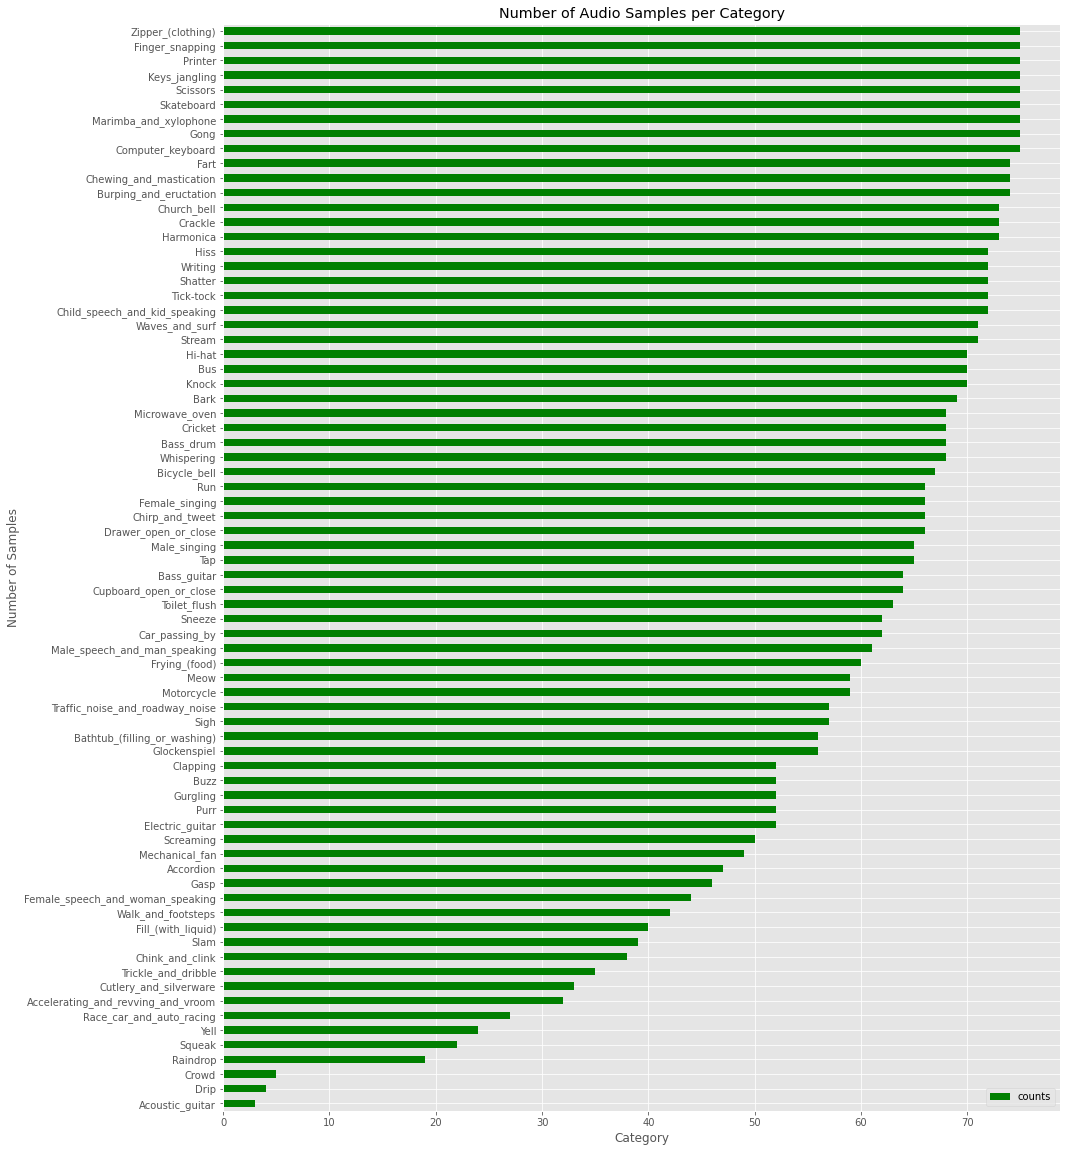

In [6]:
plot = grouped_data.sort_values(ascending = True, by='counts').plot(
    kind = 'barh', 
    title = "Number of Audio Samples per Category", 
    color = 'green', 
    figsize = (15,20))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples")

### Reading Audio Files
The audios are Pulse-code modulated with a bit depth of 16 and a sampling rate of 44.1 kHz

* <b>Bit-depth = 16:</b> The amplitude of each sample in the audio is one of 2^16 (=65536) possible values.
* <b>Samplig rate = 44.1 kHz:</b> Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100*3.2 = 141120 values.

### Transformations on a Sample: 
Lets load a sample audio and start working with it

In [7]:
import IPython.display as ipd  
sample = 'train_curated/00c40a6d.wav'
ipd.Audio(sample)

In [8]:
from scipy.io import wavfile
sample_rate, audio = wavfile.read(sample)
print("Sample rate: {0}Hz".format(sample_rate))
print("Audio duration: {0}s".format(len(audio) / sample_rate))
print("Total samples = ", audio.shape)
print(audio)

Sample rate: 44100Hz
Audio duration: 9.0s
Total samples =  (396900,)
[ 0  0  0 ... -4 -2  0]


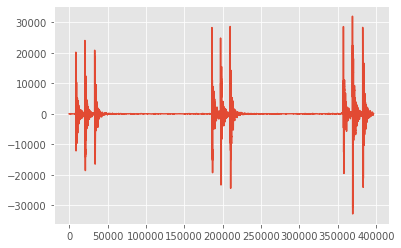

In [9]:
plt.plot(audio, '-', )

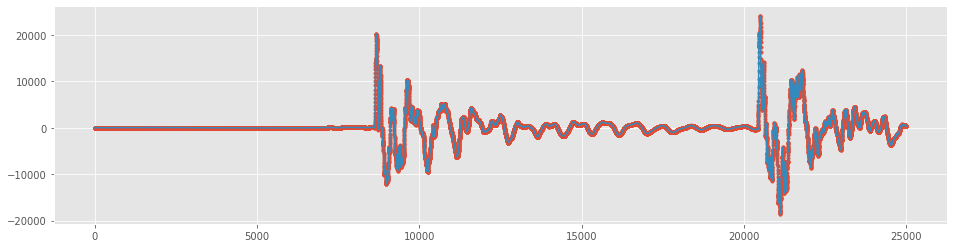

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(audio[:25000], '.'); plt.plot(audio[:25000], '-')

In [11]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

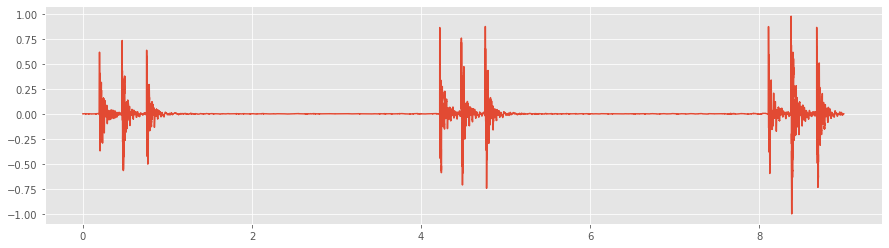

In [12]:
audio = normalize_audio(audio)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.grid(True)

### FFT
Preprocessing 

In [13]:
def frame_audio(audio, FFT_size=2048, hop_size = 10, sample_rate = 44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

In [14]:
hop_size = 15
FFT_size = 2048

audio_framed = frame_audio(audio, FFT_size=FFT_size, hop_size=hop_size, 
                           sample_rate=sample_rate)
print("Framed audio shape: {0}".format(audio_framed.shape))

Framed audio shape: (600, 2048)


### FFT
Transformation

In [15]:
import scipy.fftpack as fft
from scipy.signal import get_window

window = get_window("hann", FFT_size, fftbins=True)
audio_win = audio_framed * window

In [16]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype = np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [17]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(600, 1025)


### 3. MFCC

---
Mel Frequency Cepstral Coefficents (MFCCs) is a way of extracting features from an audio. The MFCC uses the MEL scale to divide the frequency band to sub-bands and then extracts the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

---
MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics.

In [18]:
SAMPLING_RATE = 44100 #44100
MFCC_NUM = 20
MFCC_MAX_LEN = 2000
fname = 'train_curated/00c40a6d.wav'
wav, _ = librosa.core.load(fname, sr = SAMPLING_RATE)
wav = wav[:2*44100] #44100

In [19]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLING_RATE, n_mfcc = MFCC_NUM)
mfcc.shape

(20, 173)

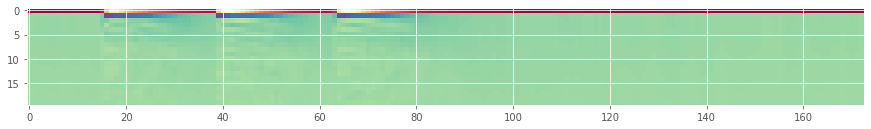

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(mfcc, cmap = 'Spectral')

In [21]:
train_curated = pd.read_csv("train_curated.csv")

In [22]:
target_labels = ['Accelerating_and_revving_and_vroom','Accordion','Acoustic_guitar','Applause','Bark','Bass_drum','Bass_guitar',
                 'Bathtub_(filling_or_washing)','Bicycle_bell','Burping_and_eructation','Bus','Buzz','Car_passing_by','Cheering',
                 'Chewing_and_mastication','Child_speech_and_kid_speaking','Chink_and_clink','Chirp_and_tweet','Church_bell','Clapping',
                 'Computer_keyboard','Crackle','Cricket','Crowd','Cupboard_open_or_close','Cutlery_and_silverware',
                 'Dishes_and_pots_and_pans','Drawer_open_or_close','Drip','Electric_guitar','Fart','Female_singing',
                 'Female_speech_and_woman_speaking','Fill_(with_liquid)','Finger_snapping','Frying_(food)','Gasp','Glockenspiel',
                 'Gong','Gurgling','Harmonica','Hi-hat','Hiss','Keys_jangling','Knock','Male_singing','Male_speech_and_man_speaking',
                 'Marimba_and_xylophone','Mechanical_fan','Meow','Microwave_oven','Motorcycle','Printer','Purr','Race_car_and_auto_racing',
                 'Raindrop','Run','Scissors','Screaming','Shatter','Sigh','Sink_(filling_or_washing)','Skateboard','Slam','Sneeze','Squeak',
                 'Stream','Strum','Tap','Tick-tock','Toilet_flush','Traffic_noise_and_roadway_noise','Trickle_and_dribble',
                 'Walk_and_footsteps','Water_tap_and_faucet','Waves_and_surf','Whispering','Writing','Yell','Zipper_(clothing)']

In [23]:
len(target_labels)

80

In [24]:
def count_labels(labels):
    array_lbs = labels.split(",")
    return len(array_lbs)

def count_target_labels(labels):
    count = 0
    array_lbs = labels.split(",")
    for lb in array_lbs:
        if lb in target_labels:
            count += 1
    return count

In [25]:
train_curated["label_count"] = train_curated["labels"].apply(count_labels)
train_curated["target_label_count"] = train_curated["labels"].apply(count_target_labels)

In [26]:
train_curated.head(15)

,fname,labels,label_count,target_label_count
0,0006ae4e.wav,Bark,1,1
1,0019ef41.wav,Raindrop,1,1
2,001ec0ad.wav,Finger_snapping,1,1
3,0026c7cb.wav,Run,1,1
4,0026f116.wav,Finger_snapping,1,1
5,003be5db.wav,Whispering,1,1
6,0041de6b.wav,"Acoustic_guitar,Strum",2,2
7,004ca909.wav,Hi-hat,1,1
8,00713ec2.wav,Bass_drum,1,1
9,0073825a.wav,"Crowd,Cheering",2,2


In [27]:
sub.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,426eb1e0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,428d70bb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4292b1c9.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,429c5071.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 4. Trasnforming Waves to MFCC

In [28]:
def wav2mfcc(wave, max_len=MFCC_MAX_LEN):
    #mfcc = librosa.feature.mfcc(wave, sr=1600)
    mfcc = librosa.feature.mfcc(wave, n_mfcc=MFCC_NUM, sr=SAMPLING_RATE)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

In [29]:
def get_label_num(labels):
    lbs = labels.split(",")
    
    target_arr = np.zeros(80)
    for lb in lbs:
        if(lb in target_labels):
            i = target_labels.index(lb)
            target_arr[i] = 1
            break
    return target_arr

In [30]:
X = []
y = []
def append_X_Y(labels, wave):
    y.append(get_label_num(labels))
    mfcc = wav2mfcc(wave)
    X.append(mfcc)

In [31]:
TRAIN_CURATED = "train_curated/"

In [32]:
for index, row in tqdm(train_curated.iterrows()):
    labels = row["labels"]
    wave, sr = librosa.load(TRAIN_CURATED + row["fname"], mono=True, sr = SAMPLING_RATE)
    wave = wave[::3]
    append_X_Y(labels, wave)

4970it [01:10, 70.80it/s] 


In [33]:
X = np.array(X)
y = np.array(y)
X.shape[0] == len(y)

True

In [34]:
y_hot = y

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hot, test_size= 0.15, random_state=True, shuffle=True)

### CNN with MFCC

In [36]:
feature_dim_1 = MFCC_NUM
feature_dim_2 = MFCC_MAX_LEN
channel = 1
epochs = 40
batch_size = 120
verbose = 1
num_classes = len(target_labels)

In [37]:
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = y_train
y_test_hot = y_test

In [38]:
mean = np.mean(X_train, axis=(1,2), keepdims=True)
std = np.std(X_train, axis=(1,2), keepdims=True)

mean_test = np.mean(X_test, axis=(1,2), keepdims=True)
std_test = np.std(X_test, axis=(1,2), keepdims=True)

X_train = (X_train - mean)/std
X_test = (X_test - mean_test)/std_test

In [39]:
import keras
from keras import optimizers
from keras import losses, models, optimizers
from keras.layers import (Convolution2D, Dropout, Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, Input, MaxPool2D, concatenate, Activation)
from keras.activations import relu, softmax
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [40]:
K.clear_session()

### 5. Model


In [41]:
def get_model():
    inp = Input(shape=((feature_dim_1, feature_dim_2, channel)))
    x = Convolution2D(32, (4,10))(inp)
    x = BatchNormalization()(x)
    x = Convolution2D(48, (4,10))(inp)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)
    x = MaxPool2D()(x)
                
    #x = Convolution2D(32, (4,10), padding="same")(x)
    #x = BatchNormalization()(x)
    #x = Activation("relu")(x)
    #x = MaxPool2D()(x)
    #
    #x = Convolution2D(32, (4,10), padding="same")(x)
    #x = BatchNormalization()(x)
    #x = Activation("relu")(x)
    #x = MaxPool2D()(x)
    #
    #x = Convolution2D(32, (4,10), padding="same")(x)
    #x = BatchNormalization()(x)
    #x = Activation("relu")(x)
    #x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(48)(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation = softmax)(x)
                
    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam()

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [42]:
Super_model = get_model()
Super_model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Epoch 1/40
36/36 [==============================] - 4s 103ms/step - loss: 4.5482 - acc: 0.0142 - val_loss: 4.2642 - val_acc: 0.0483
Epoch 2/40
36/36 [==============================] - 4s 99ms/step - loss: 4.3572 - acc: 0.0286 - val_loss: 4.1973 - val_acc: 0.0603
Epoch 3/40
36/36 [==============================] - 4s 100ms/step - loss: 4.2342 - acc: 0.0431 - val_loss: 4.1445 - val_acc: 0.0684
Epoch 4/40
36/36 [==============================] - 4s 99ms/step - loss: 4.1512 - acc: 0.0559 - val_loss: 4.1189 - val_acc: 0.0992
Epoch 5/40
36/36 [==============================] - 4s 100ms/step - loss: 4.0633 - acc: 0.0639 - val_loss: 4.0793 - val_acc: 0.1300
Epoch 6/40
36/36 [==============================] - 4s 100ms/step - loss: 3.9880 - acc: 0.0781 - val_loss: 4.0155 - val_acc: 0.1367
Epoch 7/40
36/36 [==============================] - 4s 100ms/step - loss: 3.9073 - acc: 0.0935 - val_loss: 4.0158 - val_acc: 0.1568
Epoch 8/40
36/36 [==============================] - 4s 100ms/step - loss: 3.84

### 6. Prediction on the Test Data

In [43]:
TEST = "test/"

In [46]:
for index, row in tqdm(sub.iterrows()):
    wave, sr = librosa.load(TEST + row["fname"], mono=True, sr=SAMPLING_RATE)
    wave = wave[::2]
    
    mfcc = wav2mfcc(wave)
    X_test = mfcc.reshape(1, feature_dim_1, feature_dim_2, channel)
    preds = Super_model.predict(X_test)[0]
    
    for i, col in enumerate(target_labels):
        sub.loc[index, col] = preds[i]

0it [00:00, ?it/s]

3361it [04:02, 13.87it/s]


In [47]:
sub.to_csv("submission.csv",index=False)

In [88]:
Sub = pd.read_csv("submission.csv")
Sub.head(15)

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.313502e-15,0.000000e+00,...,1.236402e-35,0.000000e+00,3.282524e-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,426eb1e0.wav,2.748178e-19,5.840076e-29,5.750964e-35,9.999995e-01,1.069451e-16,1.433311e-33,8.255197e-38,2.573982e-13,1.593764e-29,...,1.833165e-15,3.612181e-13,2.297254e-14,9.479321e-26,0.000000e+00,3.250975e-07,9.891097e-26,4.816747e-27,4.730238e-19,3.372538e-18
2,428d70bb.wav,1.566020e-13,4.714590e-18,1.690609e-13,1.243096e-05,3.888583e-21,7.195380e-29,4.701797e-20,1.110621e-08,6.130185e-23,...,8.882103e-04,4.606417e-16,2.011477e-09,1.122670e-07,0.000000e+00,8.643737e-13,2.699857e-22,7.980353e-08,1.166359e-26,5.866912e-17
3,4292b1c9.wav,8.411453e-09,7.472224e-11,9.889016e-10,2.981269e-10,9.446849e-09,3.436851e-09,5.651645e-12,3.791972e-11,1.087743e-15,...,5.415208e-11,3.200964e-08,3.723492e-10,1.178486e-06,2.595996e-22,1.134993e-13,3.653355e-04,2.005285e-10,1.178520e-10,9.099038e-04
4,429c5071.wav,1.167637e-22,0.000000e+00,0.000000e+00,2.164697e-21,3.669285e-23,0.000000e+00,0.000000e+00,2.514027e-27,1.502452e-37,...,2.013302e-32,1.119378e-12,3.123781e-29,6.325608e-30,0.000000e+00,9.815789e-19,1.821539e-33,4.422315e-34,1.340900e-36,5.410521e-21
5,42c4e76e.wav,0.000000e+00,3.356978e-38,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.937234e-19,4.039110e-29,...,1.536532e-23,0.000000e+00,7.615796e-12,3.135924e-27,0.000000e+00,0.000000e+00,1.588789e-29,1.311523e-27,0.000000e+00,1.609267e-35
6,42cbf9d5.wav,0.000000e+00,0.000000e+00,0.000000e+00,2.219911e-38,0.000000e+00,0.000000e+00,0.000000e+00,1.059731e-15,0.000000e+00,...,8.130283e-26,4.622210e-31,4.812891e-30,0.000000e+00,0.000000e+00,1.691525e-33,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,42f88540.wav,1.894951e-28,4.479412e-34,0.000000e+00,1.063067e-15,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,9.999899e-01,0.000000e+00,3.324002e-37,0.000000e+00,0.000000e+00,3.742196e-38,0.000000e+00,1.140736e-37,0.000000e+00,0.000000e+00
8,42ff5f3e.wav,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,6.621947e-10,0.000000e+00,0.000000e+00,0.000000e+00,1.427041e-32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,43023d54.wav,1.525039e-24,0.000000e+00,0.000000e+00,5.656002e-06,2.672702e-31,0.000000e+00,0.000000e+00,1.090547e-28,0.000000e+00,...,2.513166e-24,8.194114e-10,1.516544e-27,3.767981e-37,0.000000e+00,1.627771e-05,0.000000e+00,0.000000e+00,7.916885e-29,1.759807e-33


In [89]:
Sub.columns

Index(['fname', 'Accelerating_and_revving_and_vroom', 'Accordion',
       'Acoustic_guitar', 'Applause', 'Bark', 'Bass_drum', 'Bass_guitar',
       'Bathtub_(filling_or_washing)', 'Bicycle_bell',
       'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by', 'Cheering',
       'Chewing_and_mastication', 'Child_speech_and_kid_speaking',
       'Chink_and_clink', 'Chirp_and_tweet', 'Church_bell', 'Clapping',
       'Computer_keyboard', 'Crackle', 'Cricket', 'Crowd',
       'Cupboard_open_or_close', 'Cutlery_and_silverware',
       'Dishes_and_pots_and_pans', 'Drawer_open_or_close', 'Drip',
       'Electric_guitar', 'Fart', 'Female_singing',
       'Female_speech_and_woman_speaking', 'Fill_(with_liquid)',
       'Finger_snapping', 'Frying_(food)', 'Gasp', 'Glockenspiel', 'Gong',
       'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss', 'Keys_jangling', 'Knock',
       'Male_singing', 'Male_speech_and_man_speaking', 'Marimba_and_xylophone',
       'Mechanical_fan', 'Meow', 'Microwave_oven', 'Mo

---
Sub Dataset represents the probabilities of the Categorized Audio Dataset.

### A random Example or a NAIVE Examination of the model performance

In [110]:
indexed_Sub = Sub.set_index('fname')
indexed_Sub.head()

,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,Burping_and_eructation,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
fname,,,,,,,,,,,,,,,,,,,,,
4260ebea.wav,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.313502e-15,0.000000e+00,0.000000e+00,...,1.236402e-35,0.000000e+00,3.282524e-25,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
426eb1e0.wav,2.748178e-19,5.840076e-29,5.750964e-35,9.999995e-01,1.069451e-16,1.433311e-33,8.255197e-38,2.573982e-13,1.593764e-29,7.524490e-34,...,1.833165e-15,3.612181e-13,2.297254e-14,9.479321e-26,0.000000e+00,3.250975e-07,9.891097e-26,4.816747e-27,4.730238e-19,3.372538e-18
428d70bb.wav,1.566020e-13,4.714590e-18,1.690609e-13,1.243096e-05,3.888583e-21,7.195380e-29,4.701797e-20,1.110621e-08,6.130185e-23,6.438702e-32,...,8.882103e-04,4.606417e-16,2.011477e-09,1.122670e-07,0.000000e+00,8.643737e-13,2.699857e-22,7.980353e-08,1.166359e-26,5.866912e-17
4292b1c9.wav,8.411453e-09,7.472224e-11,9.889016e-10,2.981269e-10,9.446849e-09,3.436851e-09,5.651645e-12,3.791972e-11,1.087743e-15,1.373818e-09,...,5.415208e-11,3.200964e-08,3.723492e-10,1.178486e-06,2.595996e-22,1.134993e-13,3.653355e-04,2.005285e-10,1.178520e-10,9.099038e-04
429c5071.wav,1.167637e-22,0.000000e+00,0.000000e+00,2.164697e-21,3.669285e-23,0.000000e+00,0.000000e+00,2.514027e-27,1.502452e-37,0.000000e+00,...,2.013302e-32,1.119378e-12,3.123781e-29,6.325608e-30,0.000000e+00,9.815789e-19,1.821539e-33,4.422315e-34,1.340900e-36,5.410521e-21


In [111]:
other_sample = 'test/4385f4d3.wav' #Accelerating_and_revving_and_vroom
ipd.Audio(other_sample)

In [112]:
indexed_Sub.sort_values(by = '4385f4d3.wav', axis = 1, ascending=False) 

,Motorcycle,Race_car_and_auto_racing,Gong,Bus,Church_bell,Traffic_noise_and_roadway_noise,Mechanical_fan,Waves_and_surf,Printer,Applause,...,Glockenspiel,Chewing_and_mastication,Hi-hat,Keys_jangling,Knock,Male_singing,Male_speech_and_man_speaking,Marimba_and_xylophone,Chink_and_clink,Cheering
fname,,,,,,,,,,,,,,,,,,,,,
4260ebea.wav,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.804987e-36,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
426eb1e0.wav,1.881941e-17,1.819355e-18,7.382810e-19,1.090823e-22,4.860717e-11,3.612181e-13,4.238894e-20,3.250975e-07,7.340194e-16,9.999995e-01,...,0.000000e+00,1.415970e-25,6.533879e-33,9.209613e-24,3.945323e-31,2.288433e-18,3.448956e-21,6.417621e-28,3.843836e-27,3.524254e-17
428d70bb.wav,3.210350e-08,6.656437e-15,2.255307e-08,1.867244e-13,9.990395e-01,4.606417e-16,3.770519e-13,8.643737e-13,3.368344e-14,1.243096e-05,...,2.132026e-30,2.744000e-08,3.222911e-29,1.282669e-17,4.717122e-27,2.760227e-14,6.506747e-18,1.208914e-19,8.972084e-09,7.612694e-20
4292b1c9.wav,4.119789e-12,3.878739e-13,3.331986e-06,3.788300e-11,1.861572e-13,3.200964e-08,2.869132e-13,1.134993e-13,2.460082e-07,2.981269e-10,...,1.229717e-17,1.684271e-10,7.815402e-13,3.582834e-07,2.710332e-06,1.133111e-09,1.240927e-05,2.768141e-06,6.747756e-12,8.763124e-17
429c5071.wav,9.222424e-03,1.011159e-11,5.086091e-13,4.713471e-07,3.029415e-15,1.119378e-12,2.852358e-02,9.815789e-19,4.911748e-24,2.164697e-21,...,0.000000e+00,6.247173e-36,0.000000e+00,1.112286e-35,6.721704e-34,0.000000e+00,1.774736e-31,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffd7e42d.wav,7.890295e-26,6.487491e-31,8.516807e-19,1.443920e-24,1.078432e-22,1.801521e-20,1.768358e-25,1.580987e-22,1.036214e-19,6.431463e-22,...,4.793088e-14,4.564036e-22,4.335126e-15,1.187960e-14,2.394057e-11,2.505229e-30,4.428330e-20,2.910265e-08,3.148996e-21,2.041181e-27
ffddb54a.wav,3.934089e-30,6.932003e-33,6.947418e-01,8.847794e-24,7.946851e-26,1.182666e-38,3.216185e-35,2.408630e-33,1.716087e-13,0.000000e+00,...,1.225753e-25,2.437004e-14,4.320735e-15,4.908323e-10,2.974218e-24,0.000000e+00,2.556297e-33,2.029166e-12,3.778435e-06,0.000000e+00
ffe097a2.wav,5.398652e-10,9.999856e-01,1.726874e-19,2.874655e-21,1.039484e-06,8.013847e-28,2.511227e-19,7.256494e-14,2.081328e-23,1.336029e-05,...,0.000000e+00,0.000000e+00,6.678214e-37,0.000000e+00,0.000000e+00,1.290851e-25,1.456686e-38,0.000000e+00,0.000000e+00,4.796437e-27
